In [7]:
from denovo_utils.parsers.converters import SpectralisParser, DenovoEngineConverter
import pandas as pd
import os

from matplotlib import pyplot as plt
import seaborn as sns

from psm_utils import PSM, PSMList
from tqdm import tqdm
from denovo_utils.analysis.mixture_models import assign_ggm_clusters, plot_cluster_psmtype, get_ggm_n_clusters
from denovo_utils.analysis.pandas_utils import get_psm_type

---

In the following analysis, all identifications with a modification at a certain location are removed

# FDR-thresholding and evaluation (written summary)

There are four ways in which I (and others) envision FDR for de novo.

## 1. Based on Spectralis score

The spectralis rescorer can function as an analogous scoring metric as percolator. By defining a threshold by doing a target decoy split at a predefined FDR based on this score alone, this can be generalized to other sequences as well, for instance those generated by de novo tools. Based on this hard threshold defined by a database-assisted target-decoy approach, when can count how many of those sequences are of acceptable quality. However, a caveat here, is that we assume the score from spectralis to follow those defined by percolator. However, as can be seen in the 2_exploration.ipynb notebook, this does not hold.

## 2. Nokoi-like approach

A decoy-free way to calculate an empirical FDR, is by leveraging mixture models. Mixture models can group PSMs into distinct normal distributions. There are two assumptions here:

1. De novo tools output scores which correctly estimate the confidence of the PSM, where very good hits such as true hits follow a different distribution than clearly false hits. It is expected that many PSMs follow a third distribution which falls between clearly false and very easy predictions. These reflect partially correct predictions.
2. The second assumption is directly related to the distribution profile of the dataset. It is expected that the predictions from de novo tools follow a normal distribution. This assumes that the scores generated by the tools are well calibrated.

## 3. Empirical, brute-force thresholding

This approach requires a ground-truth dataset, which somewhat defeats the purpose of FDR. With this approach, an accuracy curve is plotted by comparing the predictions of the de novo tool to the ground-truth dataset. This way, one can estimate which score of the de novo tool corresponds with confident (and thus highly accurate) peptide sequence predictions. The assumptions here are similar as the first one from the Nokoi appraoch, that is, the scores reflect the correctness of the prediction in an accurate way.

## 4. NovoBoard approach

The last approach was proposed by the authors of NovoBoard. This approach is based on the generation of a set of decoy spectra, which are also used to predict a de novo peptide sequence. Based on the scores of the de novo tools, one can easily estimate a cutoff value which corresponds with a lower bound 1% FDR. The authors emphasize that the resulting FDR is a lower bound of the true FDR.

Below, most of these approaches will be explored.

---

# 0. Load data

In [3]:
df = pd.read_pickle("F06_merged.pkl")

---

# 1. Thresholding on Spectralis score

### 1.1 Acquire a suitable spectralis-score for cutoff

In [4]:
df_sage = df[df["source"]=="sage"]

<Axes: xlabel='spectralis_score', ylabel='Count'>

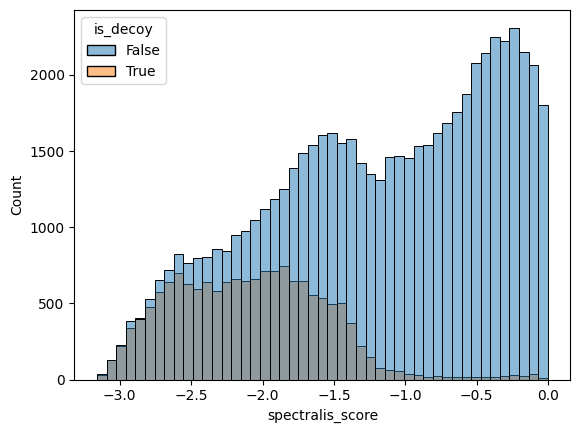

In [5]:
sns.histplot(
    df_sage,
    x="spectralis_score",
    hue="is_decoy"
)

In [6]:
df_sage_td = df_sage.copy()
df_sage_td["score"] = df_sage_td["spectralis_score"]

In [9]:
sage_td_psmlist = PSMList(psm_list = [PSM(**x) for x in df_sage_td.to_dict("records")])

In [10]:
sage_td_psmlist.calculate_qvalues()

In [15]:
sage_qvalues_df = sage_td_psmlist.to_dataframe()
sage_qvalues_df["psm_type"] = sage_qvalues_df.apply(lambda x: get_psm_type(x, cutoff=.05), axis=1)

target_accepted    35456
target_rejected    25311
decoy              15414
Name: psm_type, dtype: int64


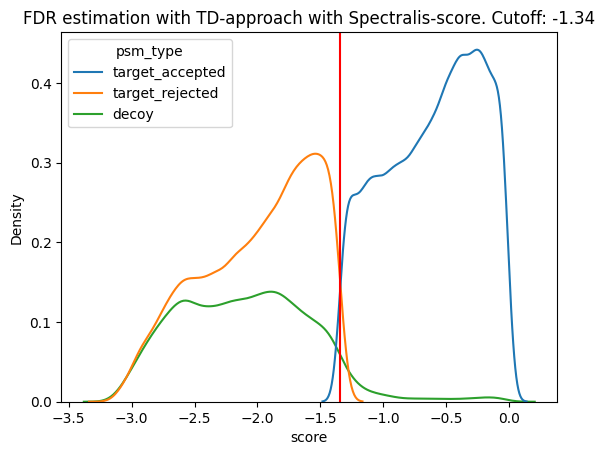

In [16]:
sns.kdeplot(
    sage_qvalues_df,
    x="score",
    hue="psm_type"
)
cutoff_value = sage_qvalues_df[sage_qvalues_df["psm_type"]=="target_rejected"]["score"].max()
plt.axvline(
    cutoff_value,
    c="r"
)

plt.title("FDR estimation with TD-approach with Spectralis-score. Cutoff: {:.2f}".format(cutoff_value))
print(sage_qvalues_df["psm_type"].value_counts())

In [18]:
print(
    "max discarded score: {:.2f}\nmin accepted score: {:.2f}".format(
        sage_qvalues_df[sage_qvalues_df["psm_type"]=="target_rejected"]["score"].max(),
        sage_qvalues_df[sage_qvalues_df["psm_type"]=="target_accepted"]["score"].min(),
    )
)

max discarded score: -1.34
min accepted score: -1.34


The Spectralis-score threshold for F06 seems to lie at -1.34

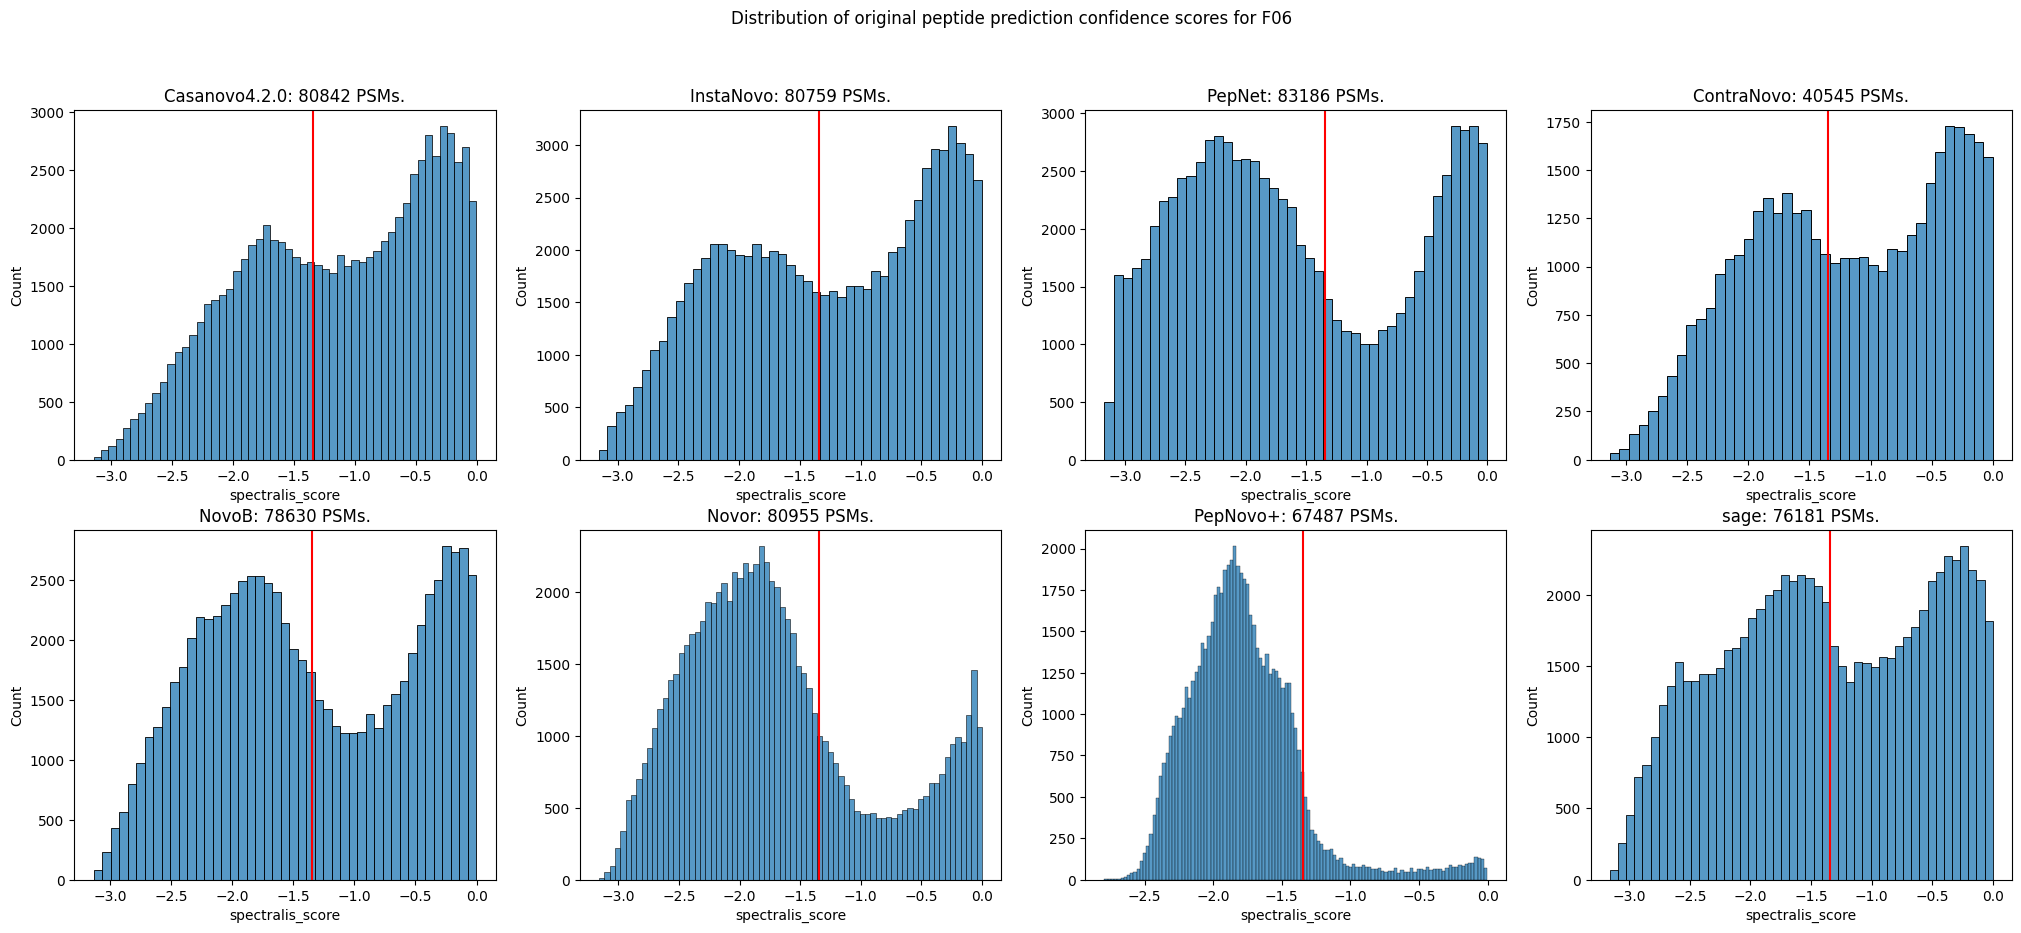

In [19]:
fig, ax = plt.subplots(2,4, figsize=(25,10))

x=0

fig.suptitle("Distribution of original peptide prediction confidence scores for F06")
for y, engine in enumerate(df.source.unique()):
    if y >= 4:
        x=1
        y-=4
    selection = df[
        df.source==engine
    ]
    sns.histplot(
        selection["spectralis_score"],
        ax=ax[x][y]
    )
    ax[x][y].set_title(f"{engine}: {len(selection)} PSMs.")
    ax[x][y].axvline(
        cutoff_value,
        c="r"
    )

Clearly, from visual inspectrion, this threshold doesn't feel satisfiable. It looks like the correct split is around -1. Maybe this will be fixed when performing the search with Sage

In [20]:
df["above_spectralis_threshold"] = df["spectralis_score"]>cutoff_value

In [22]:
df_counts = df.groupby("source")["above_spectralis_threshold"].value_counts()
df_counts.name="count"
df_counts=df_counts.reset_index()

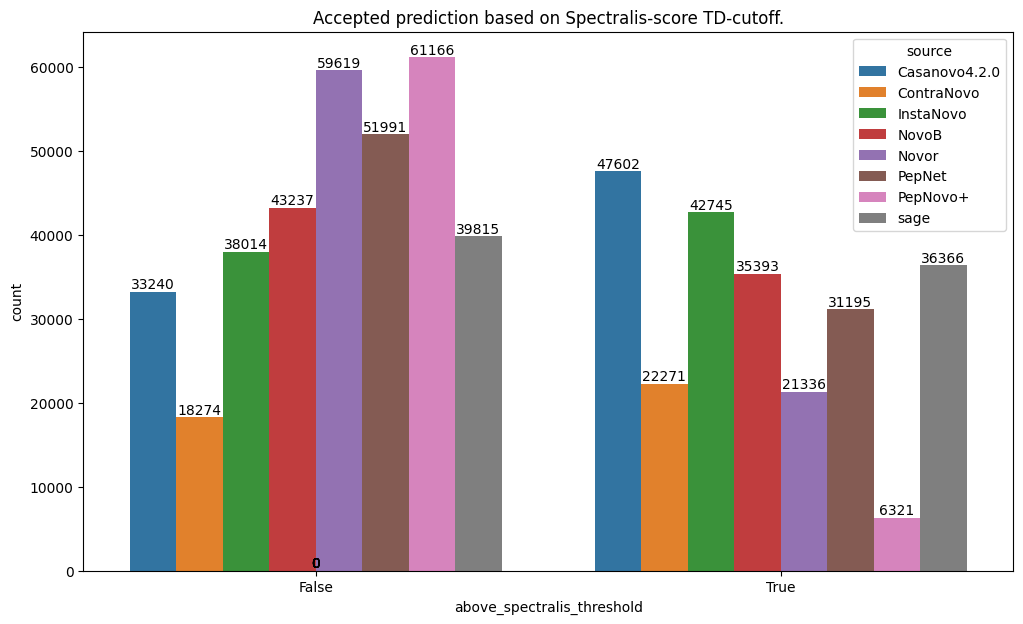

In [23]:
# Evaluation based on the number of sequences that are above the threshold

plt.figure(figsize=(12,7))
plt.title("Accepted prediction based on Spectralis-score TD-cutoff.")

barplot = sns.barplot(
    df_counts,
    y="count",
    x="above_spectralis_threshold",
    hue="source"
)

# Annotate the bars
for p in barplot.patches:
    height = p.get_height()
    barplot.text(
        p.get_x() + p.get_width() / 2.0,  # X-coordinate: center of the bar
        height,  # Y-coordinate: height of the bar
        f'{height:.0f}',  # Text to be displayed
        ha='center',  # Horizontal alignment
        va='bottom'   # Vertical alignment
    )

plt.show()

---

# 2. Using Gaussian mixture models to set confidence

Get optimal number of distributions

/home/samva/miniconda3/envs/denovo_analysis_env/lib/python3.11/site-packages/IPython/core/events.py:82: UserWarning: Glyph 9 (	) missing from font(s) STIXGeneral.
  func(*args, **kwargs)
/home/samva/miniconda3/envs/denovo_analysis_env/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 9 (	) missing from font(s) STIXGeneral.
  fig.canvas.print_figure(bytes_io, **kw)


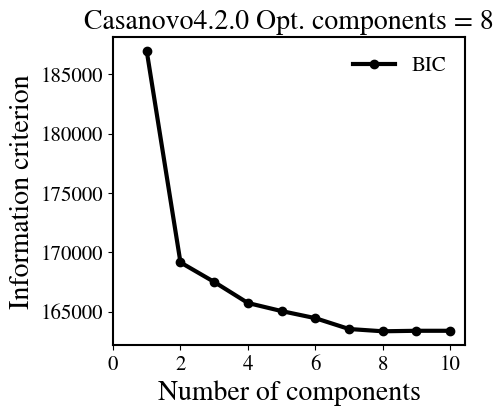

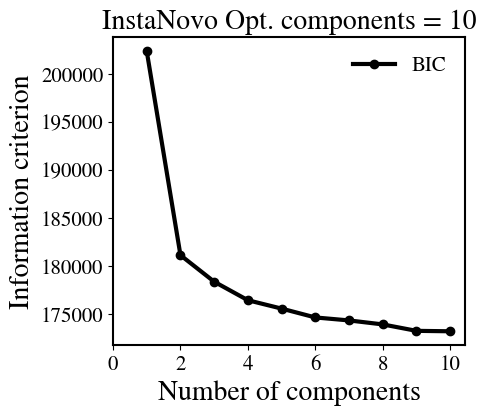

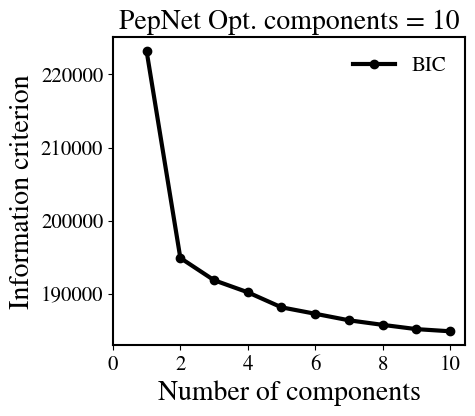

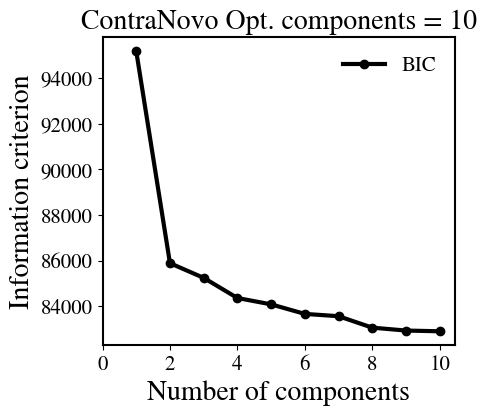

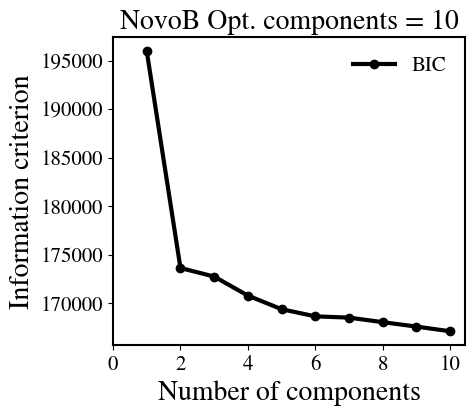

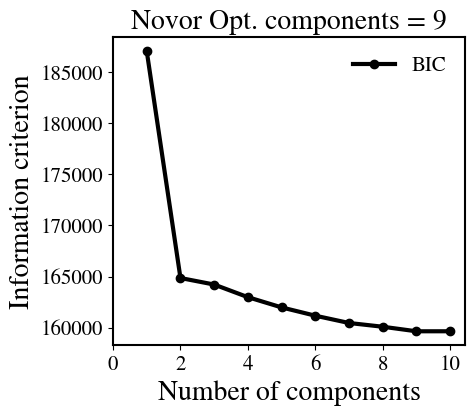

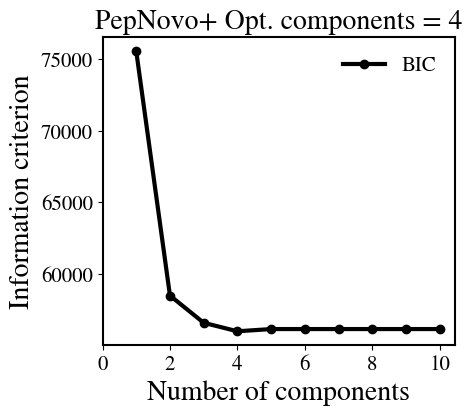

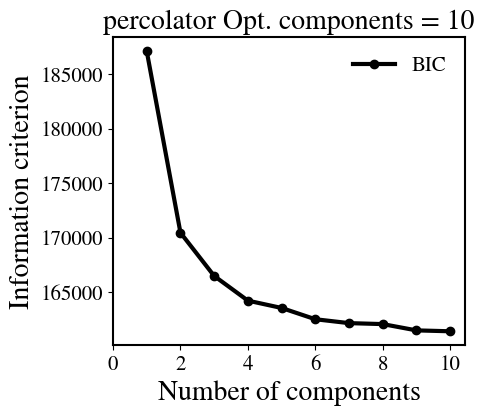

In [6]:
for engine in df["source"].unique():
    get_ggm_n_clusters(df[df["source"]==engine]["spectralis_score"].to_numpy(), search_engine=engine)

Assign clusters

In [24]:
gmm_variables = {}
df["gmm_cluster"] = None

for engine in tqdm(df["source"].unique()):
    labels, mean, covs, weights = assign_ggm_clusters(
        df[df["source"]==engine]["spectralis_score"].to_numpy(), n_clusters=2
    )
    gmm_variables[engine] = {
        "labels": labels,
        "mean": mean,
        "covs": covs,
        "weights": weights
    }
    df[df["source"]=="engine"]["gmm_cluster"] = labels

  0%|          | 0/8 [00:00<?, ?it/s]/tmp/ipykernel_833992/2590376505.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[df["source"]=="engine"]["gmm_cluster"] = labels
 12%|█▎        | 1/8 [00:00<00:04,  1.42it/s]

Mean: [-1.69476715 -0.44005902]
Covariance: [0.3005588  0.07899656]
Weights: [0.57127841 0.42872159]


/tmp/ipykernel_833992/2590376505.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[df["source"]=="engine"]["gmm_cluster"] = labels
 25%|██▌       | 2/8 [00:01<00:03,  1.54it/s]

Mean: [-0.46489664 -1.90170313]
Covariance: [0.09322216 0.30001458]
Weights: [0.43179384 0.56820616]


/tmp/ipykernel_833992/2590376505.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[df["source"]=="engine"]["gmm_cluster"] = labels
 38%|███▊      | 3/8 [00:01<00:03,  1.58it/s]

Mean: [-2.07621228 -0.36915542]
Covariance: [0.33558789 0.06352089]
Weights: [0.710585 0.289415]


/tmp/ipykernel_833992/2590376505.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[df["source"]=="engine"]["gmm_cluster"] = labels
 50%|█████     | 4/8 [00:02<00:02,  1.75it/s]

Mean: [-1.71837851 -0.41420985]
Covariance: [0.29423516 0.07196041]
Weights: [0.61176925 0.38823075]


/tmp/ipykernel_833992/2590376505.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[df["source"]=="engine"]["gmm_cluster"] = labels
 62%|██████▎   | 5/8 [00:03<00:01,  1.65it/s]

Mean: [-1.87071152 -0.3837062 ]
Covariance: [0.29374453 0.06615471]
Weights: [0.6700148 0.3299852]


/tmp/ipykernel_833992/2590376505.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[df["source"]=="engine"]["gmm_cluster"] = labels
 75%|███████▌  | 6/8 [00:03<00:01,  1.60it/s]

Mean: [-0.32333867 -1.95957662]
Covariance: [0.05659333 0.25331423]
Weights: [0.16520316 0.83479684]


/tmp/ipykernel_833992/2590376505.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[df["source"]=="engine"]["gmm_cluster"] = labels
 88%|████████▊ | 7/8 [00:04<00:00,  1.55it/s]

Mean: [-1.17055826 -1.86154601]
Covariance: [0.43800264 0.08737488]
Weights: [0.11925074 0.88074926]


/tmp/ipykernel_833992/2590376505.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[df["source"]=="engine"]["gmm_cluster"] = labels
100%|██████████| 8/8 [00:05<00:00,  1.57it/s]

Mean: [-1.85835212 -0.46244138]
Covariance: [0.34477204 0.08599153]
Weights: [0.65121246 0.34878754]


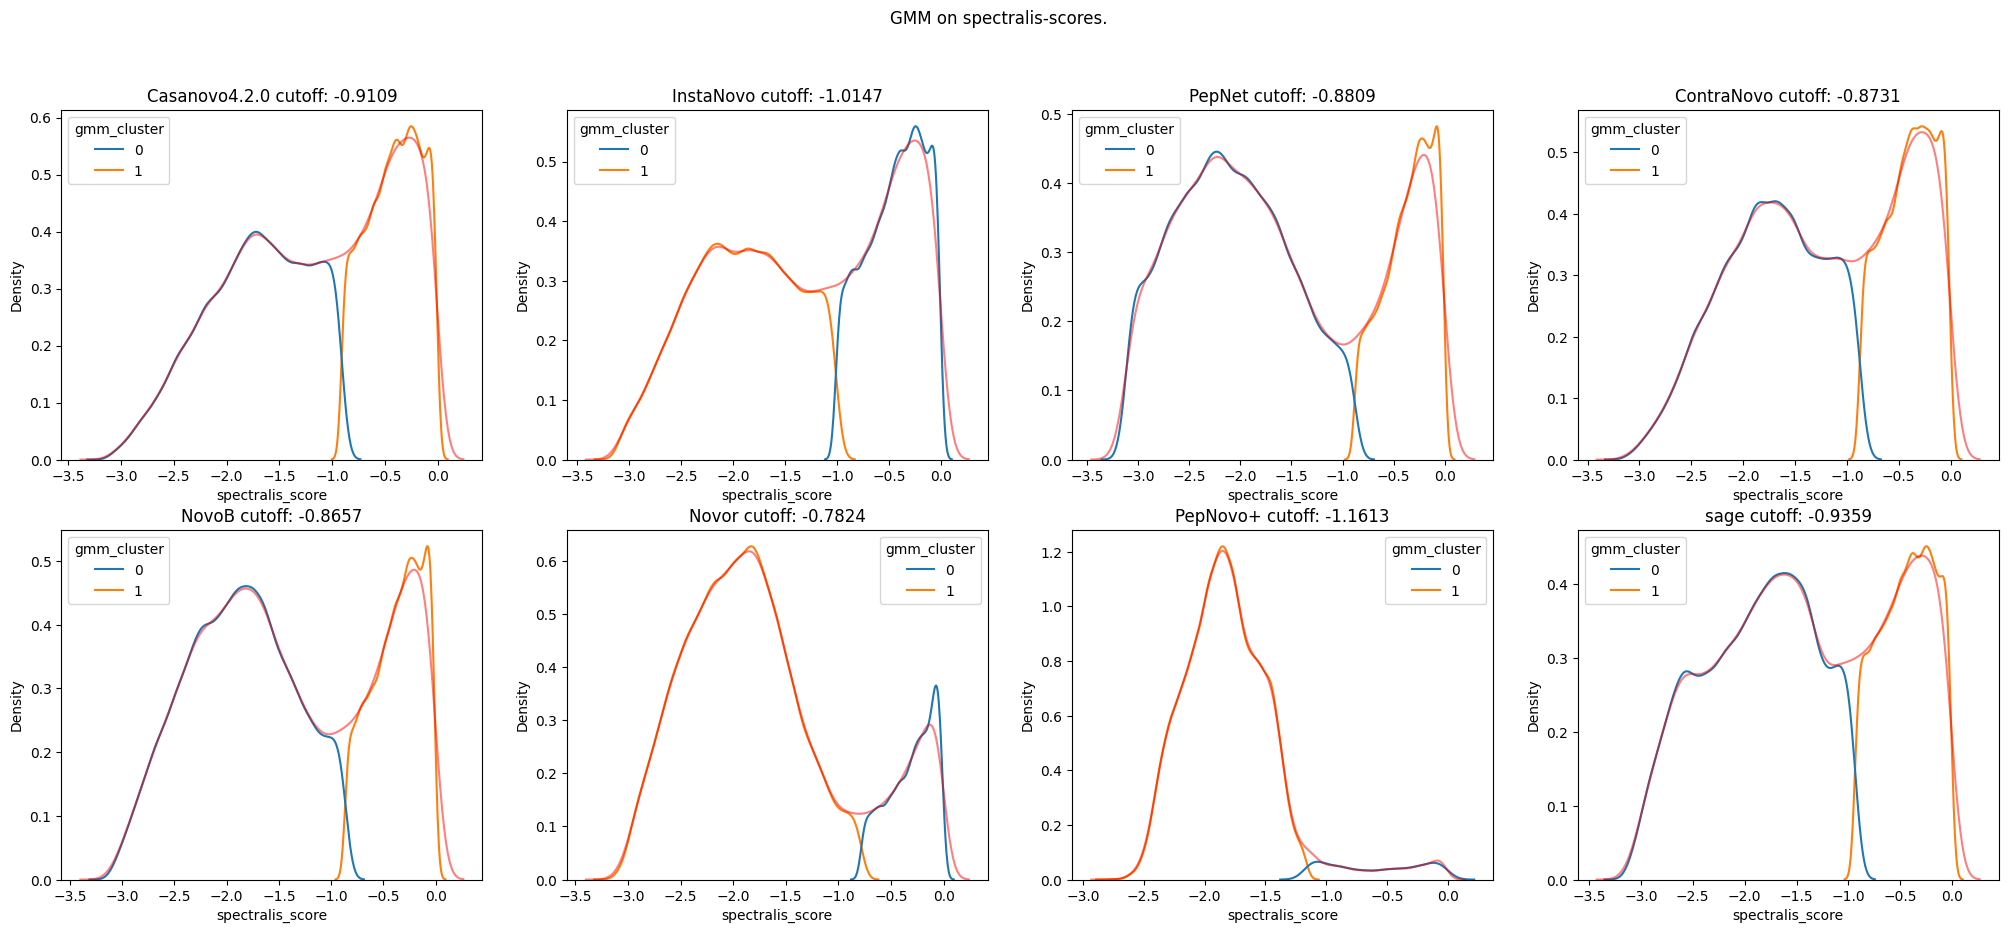

In [25]:
fig, ax = plt.subplots(2,4, figsize=(25,10))

x=0

spectrum_in_high_cluster = {}

fig.suptitle("GMM on spectralis-scores.")
for y, engine in enumerate(df.source.unique()):
    if y >= 4:
        x=1
        y-=4
    selection = df[
        df.source==engine
    ].copy()

    selection["gmm_cluster"] = gmm_variables[engine]["labels"]
    sns.kdeplot(
        selection,
        x="spectralis_score",
        hue="gmm_cluster",
        ax=ax[x][y]
    )
    sns.kdeplot(selection,
                x="spectralis_score",
                color="r", alpha=.5,
                ax=ax[x][y])
    
    cutoff = max(
        selection[selection["gmm_cluster"]==0]["spectralis_score"].min(),
        selection[selection["gmm_cluster"]==1]["spectralis_score"].min()
    )
    ax[x][y].set_title("{} cutoff: {:.4f}".format(engine, cutoff))

    highest_cluster = selection.groupby("gmm_cluster")["spectralis_score"].max().idxmax()

    spectrum_in_high_cluster[engine] = set(selection.loc[selection["gmm_cluster"]==highest_cluster, "spectrum_id"].tolist())

In [57]:
# How valid is this split
df_sage = df.loc[df["source"]=="sage", ["spectrum_id", "score", "psm_type", "spectralis_score", "gmm_cluster"]].copy()

In [58]:
df_sage["gmm_cluster"] = df_sage["spectrum_id"].isin(spectrum_in_high_cluster["sage"])

<Axes: xlabel='spectralis_score', ylabel='Density'>

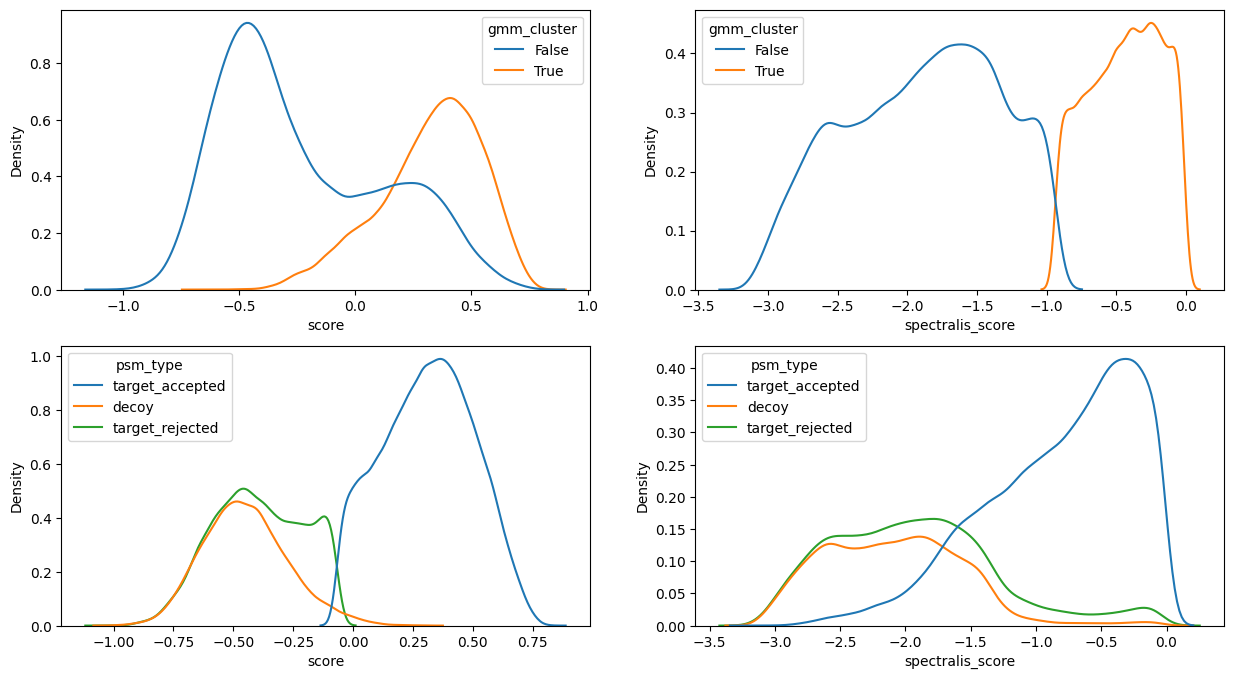

In [62]:
fig, ax = plt.subplots(2,2, figsize=(15,8))

sns.kdeplot(
    df_sage,
    x="score",
    hue="gmm_cluster",
    ax=ax[0][0]
)
sns.kdeplot(
    df_sage,
    x="spectralis_score",
    hue="gmm_cluster",
    ax=ax[0][1]
)
sns.kdeplot(
    df_sage,
    x="score",
    hue="psm_type",
    ax=ax[1][0]
)
sns.kdeplot(
    df_sage,
    x="spectralis_score",
    hue="psm_type",
    ax=ax[1][1]
)

In [48]:
df_sage[["gmm_cluster", "is_decoy"]].value_counts()

gmm_cluster  is_decoy
False        False       33881
True         False       26886
False        True        15114
True         True          300
dtype: int64

<Axes: title={'center': 'Number of spectra in high scoring cluster'}>

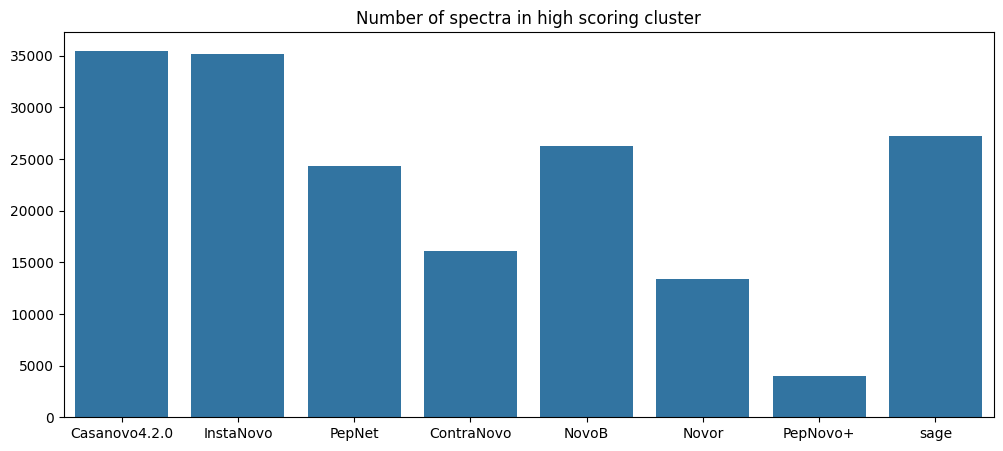

In [26]:
plt.figure(figsize=(12,5))
plt.title("Number of spectra in high scoring cluster")
sns.barplot({k: len(v) for k, v in spectrum_in_high_cluster.items()})

Text(0.5, 1.0, 'Overlap of spectrum_ids in the high scoring cluster')

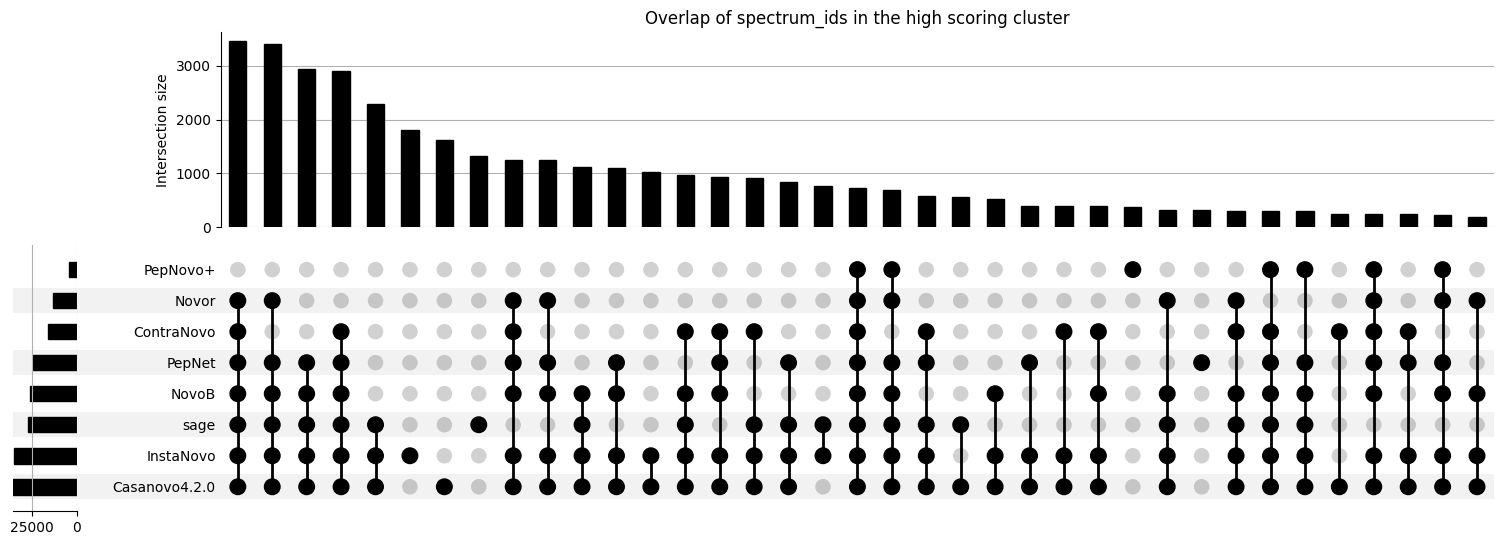

In [27]:
import upsetplot

data = upsetplot.from_contents(spectrum_in_high_cluster)
upsetplot.plot(data, min_subset_size=200, sort_by="cardinality")
plt.title("Overlap of spectrum_ids in the high scoring cluster")

Plot spectrum annotations

### Which engine outputs the highest scoring prediction per spectrum?

Only do this for targets

In [28]:
target_spectra = df_sage[
    (~df_sage["is_decoy"]) &
    (df_sage["qvalue"]<.01)].spectrum_id

In [29]:
spectralis_score_matrix = df[["spectrum_id", "spectralis_score", "source"]].pivot_table(
    index="spectrum_id", columns="source", values="spectralis_score"
)

spectralis_score_matrix = spectralis_score_matrix[spectralis_score_matrix["sage"].notna()]

In [30]:
spectralis_score_matrix_ranked = spectralis_score_matrix.rank(axis=1, ascending=False, method="min")

In [31]:
spectralis_score_matrix_ranked_selection = spectralis_score_matrix_ranked.loc[
    target_spectra,:
]

<Axes: xlabel='source'>

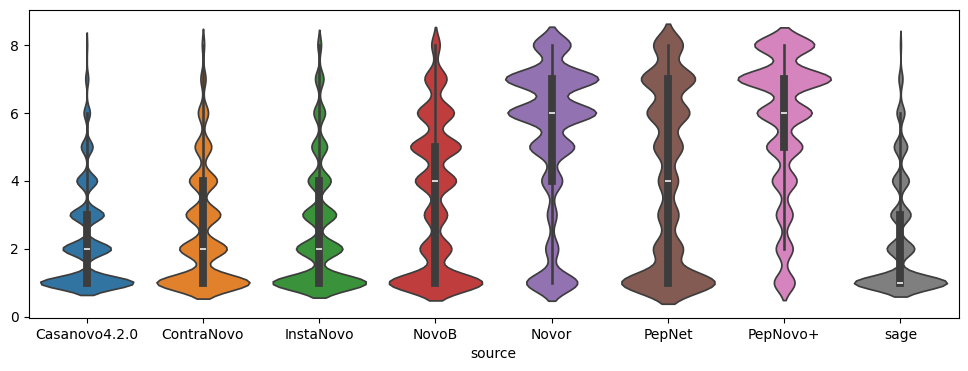

In [33]:
plt.figure(figsize=(12,4))
sns.violinplot(spectralis_score_matrix_ranked_selection)

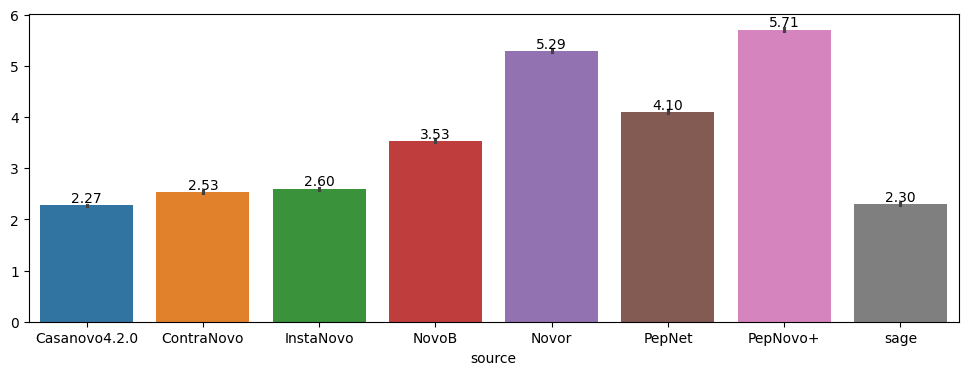

In [36]:
plt.figure(figsize=(12,4))
barplot = sns.barplot(spectralis_score_matrix_ranked_selection)

# Annotate the bars
for p in barplot.patches:
    height = p.get_height()
    barplot.text(
        p.get_x() + p.get_width() / 2.0,  # X-coordinate: center of the bar
        height,  # Y-coordinate: height of the bar
        f'{height:.2f}',  # Text to be displayed
        ha='center',  # Horizontal alignment
        va='bottom'   # Vertical alignment
    )

plt.show()

---

# 3. Using an accuracy metric: see notebook 4